In [1]:
import os
import PIL
import PIL.Image
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import urllib

from IPython.display import Image, display


In [2]:
#Load the data
(train_ds, val_ds, test_ds), metadata = tfds.load("OxfordIIITPet", split=["train + test[:70%]", "test[70%:90%]", "test[90%:]"],as_supervised=True, with_info=True)


In [3]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

37


In [4]:
# assign the labels to a variable to make showing the label easier
labels = metadata.features['label'].names

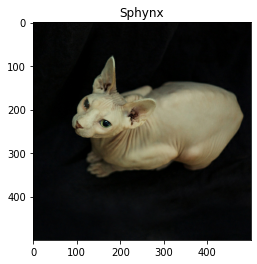

In [5]:
get_label_name = metadata.features['label'].int2str
image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [6]:
#Resize and Rescale
IMG_SIZE = 224
resize_and_rescale = tf.keras.Sequential([
                                          tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
                                          tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
])

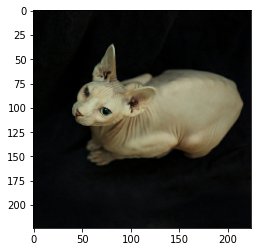

In [7]:
result = resize_and_rescale(image)
_ = plt.imshow(result)

In [8]:
result.numpy().min(), result.numpy().max()

(0.0, 0.7977198)

In [9]:
data_augmentation = tf.keras.Sequential([
                                         tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
                                         tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
                                         tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
])

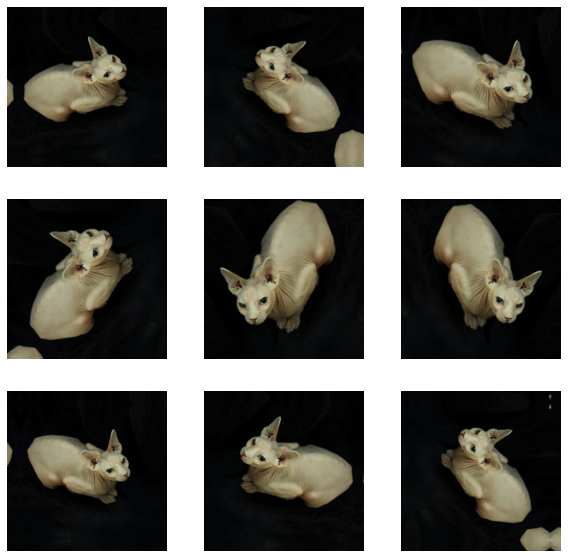

In [10]:
# Add the image to a batch
image = tf.squeeze(image)
image = tf.expand_dims(image, 0)
plt.figure(figsize=(10,10))
for i in range(9):
    augmented_image = data_augmentation(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0])
    plt.axis("off")

In [11]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE
def prepare(ds, shuffle=False, augment=False):
    #resize and rescale all datasets
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)

    # Batch the datasets
    ds = ds.batch(batch_size)

    # Augmentation on the training set
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

    # Use buffered prefetching on all datasets
    return ds.prefetch(buffer_size=AUTOTUNE)

In [12]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

model = tf.keras.Sequential([
                             tf.keras.layers.Conv2D(16, (3,3), padding="same", activation="relu"),
                             tf.keras.layers.MaxPooling2D(2,2),
                             tf.keras.layers.Conv2D(32, (3,3), padding="same", activation="relu"),
                             tf.keras.layers.MaxPooling2D(2,2),
                             tf.keras.layers.Conv2D(64, (3,3), padding="same", activation="relu"),
                             tf.keras.layers.MaxPooling2D(2,2),
                             tf.keras.layers.Conv2D(64, (3,3), padding="same", activation="relu"),
                             tf.keras.layers.MaxPooling2D(2,2),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(128, activation="relu"),
                             tf.keras.layers.Dense(num_classes)
])

model.compile(optimizer="adam", 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


"""epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)"""

In [13]:
pre_trained_model = tf.keras.applications.MobileNetV2(include_top = False, input_shape=(224,224,3), weights="imagenet")

In [14]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = pre_trained_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [15]:
pre_trained_model.trainable = False



In [16]:
pre_trained_model.summary()

xpand_relu[0][0]        
__________________________________________________________________________________________________
block_6_depthwise (DepthwiseCon (None, 14, 14, 192)  1728        block_6_pad[0][0]                
__________________________________________________________________________________________________
block_6_depthwise_BN (BatchNorm (None, 14, 14, 192)  768         block_6_depthwise[0][0]          
__________________________________________________________________________________________________
block_6_depthwise_relu (ReLU)   (None, 14, 14, 192)  0           block_6_depthwise_BN[0][0]       
__________________________________________________________________________________________________
block_6_project (Conv2D)        (None, 14, 14, 64)   12288       block_6_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_6_project_BN (BatchNormal (None, 14, 14, 64)   256         block_6_project[0][

In [17]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


# freeze all the layers
for layer in pre_trained_model.layers:
    layer.trainable = False

last_layer = pre_trained_model.get_layer(index=-34)
print("last layer output shape: ", last_layer.output_shape)
last_output = last_layer.output




In [18]:
prediction_layer = tf.keras.layers.Dense(num_classes, activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 37)


In [19]:
inputs = tf.keras.Input(shape=(224,224,3))
x = pre_trained_model(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [20]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 37)                47397     
Total params: 2,305,381
Trainable params: 47,397
Non-trainable params: 2,257,984
_________________________________________________________________


In [22]:
len(model.trainable_variables)

2

In [23]:
epochs = 20
loss0, accuracy0 = model.evaluate(val_ds)

23/23 [==============================] - 12s 470ms/step - loss: 3.9250 - accuracy: 0.0185


In [24]:
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/20
196/196 [==============================] - 115s 572ms/step - loss: 3.3073 - accuracy: 0.1346 - val_loss: 2.4401 - val_accuracy: 0.3774
Epoch 2/20
196/196 [==============================] - 118s 598ms/step - loss: 2.2747 - accuracy: 0.3976 - val_loss: 1.6527 - val_accuracy: 0.6362
Epoch 3/20
196/196 [==============================] - 116s 587ms/step - loss: 1.7278 - accuracy: 0.5479 - val_loss: 1.2146 - val_accuracy: 0.7520
Epoch 4/20
196/196 [==============================] - 117s 590ms/step - loss: 1.4030 - accuracy: 0.6186 - val_loss: 0.9709 - val_accuracy: 0.8011
Epoch 5/20
196/196 [==============================] - 118s 597ms/step - loss: 1.2296 - accuracy: 0.6674 - val_loss: 0.8183 - val_accuracy: 0.8215
Epoch 6/20
196/196 [==============================] - 117s 590ms/step - loss: 1.0971 - accuracy: 0.7050 - val_loss: 0.7124 - val_accuracy: 0.8338
Epoch 7/20
196/196 [==============================] - 116s 584ms/step - loss: 1.0279 - accuracy: 0.7113 - val_loss: 0.6417 -

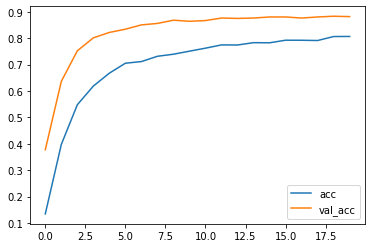

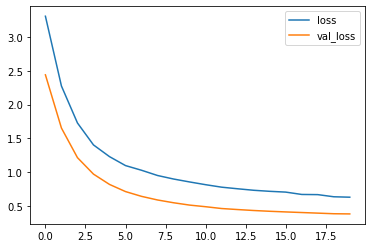

In [25]:
plt.plot(history.history['accuracy'], label="acc")
plt.plot(history.history['val_accuracy'], label="val_acc")
plt.legend()
plt.show()

plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

In [26]:
# Train more layers - Fine Tune the model
pre_trained_model.trainable = True


In [27]:
fine_tune_at = 100
for layer in pre_trained_model.layers[:fine_tune_at]:
    layer.trainable = False

In [28]:
len(pre_trained_model.trainable_variables)

54

In [29]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate/10), metrics=['accuracy'])

In [30]:
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 37)                47397     
Total params: 2,305,381
Trainable params: 1,908,837
Non-trainable params: 396,544
_________________________________________________________________


In [31]:
len(model.trainable_variables)

56

In [32]:
fine_tune_epochs = 10
total_epochs = epochs + fine_tune_epochs
history_fine = model.fit(train_ds, epochs=total_epochs, initial_epoch=history.epoch[-1], validation_data=val_ds)

Epoch 20/30
196/196 [==============================] - 171s 850ms/step - loss: 0.5615 - accuracy: 0.8167 - val_loss: 0.3286 - val_accuracy: 0.8910
Epoch 21/30
196/196 [==============================] - 166s 844ms/step - loss: 0.5494 - accuracy: 0.8128 - val_loss: 0.2932 - val_accuracy: 0.9114
Epoch 22/30
196/196 [==============================] - 166s 843ms/step - loss: 0.4962 - accuracy: 0.8432 - val_loss: 0.3062 - val_accuracy: 0.9046
Epoch 23/30
196/196 [==============================] - 167s 843ms/step - loss: 0.4626 - accuracy: 0.8484 - val_loss: 0.2901 - val_accuracy: 0.9114
Epoch 24/30
196/196 [==============================] - 167s 846ms/step - loss: 0.4670 - accuracy: 0.8475 - val_loss: 0.2854 - val_accuracy: 0.9128
Epoch 25/30
196/196 [==============================] - 166s 840ms/step - loss: 0.4333 - accuracy: 0.8496 - val_loss: 0.2903 - val_accuracy: 0.9074
Epoch 26/30
196/196 [==============================] - 167s 846ms/step - loss: 0.4208 - accuracy: 0.8548 - val_loss: 0

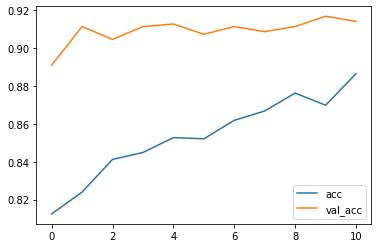

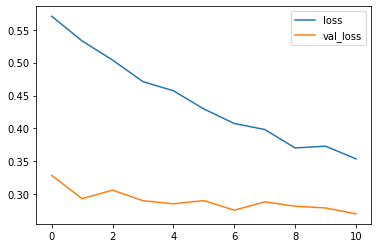

In [33]:
plt.plot(history_fine.history['accuracy'], label="acc")
plt.plot(history_fine.history['val_accuracy'], label="val_acc")
plt.legend()
plt.show()

plt.plot(history_fine.history['loss'], label="loss")
plt.plot(history_fine.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

In [34]:
# Save the model (about 20MB in total :-))
model.save("pets_mobilenet")


INFO:tensorflow:Assets written to: pets_mobilenet/assets
INFO:tensorflow:Assets written to: pets_mobilenet/assets


In [35]:
# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_saved_model("pets_mobilenet")
tflite_model = converter.convert()

with open("model.tflite", "wb") as f:
    f.write(tflite_model)

In [36]:
# Check how well the model does on the test Dataset (now that I'm done fine tuning)
model.evaluate(test_ds)

12/12 [==============================] - 6s 523ms/step - loss: 0.3453 - accuracy: 0.8856


[0.3453280031681061, 0.8855586051940918]